In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import os
from datetime import date, datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
sns.set()
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler
from pandas_profiling import ProfileReport
import statistics
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score

In [2]:
#imports dataset
#dataset = #dataset name
path = os.path.join('Outliers_Removed_notstd.csv')
df = pd.read_csv(path)

In [3]:
clustering_features = ["LONGEVITY","RAMNTALL","NGIFTALL","PROP_RESP_CARDPROM","HVP4","IC5","EC4"]

# SCALING, NORMALIZATION

In [4]:
df_norm = df.copy()

In [5]:
# Scales the data

# Get column names first
names = df_norm[clustering_features].columns
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_norm[clustering_features])

#Normalizing the Data 
normalized_df =normalize(scaled_feat) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df, index=df.index,columns=names) 

# K-means CLUSTERING

In [6]:
df_cluster = normalized_df

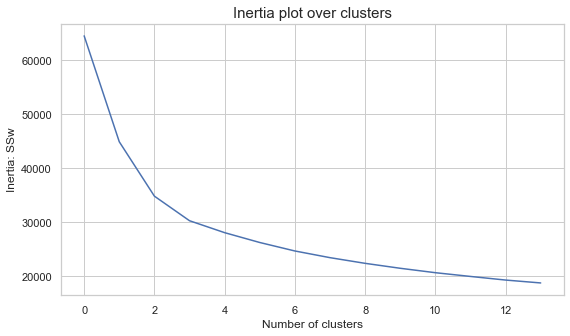

In [7]:
#Let's check the optimal number of clusters to keep with an elbow plot

sns.set_style(style="whitegrid")

range_clusters = range(1, 15)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    kmclust.fit(df_cluster)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [8]:
#Let's use 6 clusters!

# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=6, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_cluster) #performs clustering ie finds centroids

KMeans(n_clusters=6, n_init=15, random_state=15)

In [9]:
#location of each point
# the transform method
dist_matrix = pd.DataFrame(kmclust.transform(df_cluster)) #calculates distance of each sample to respective centroid

In [10]:
# the predict method
km_labels = kmclust.predict(df_cluster) #associates/predicts cluster index for each sample, based on min distance

In [11]:
###THIS GIVES US THE CENTROIDS. interpretation of the clusters; the higher the value, the more related a cluster is to a certain variable

# Characterizing the final clusters
df_concat = pd.concat((df_cluster, pd.Series(km_labels, name='labels')), axis=1)

df_centroids = df_concat.groupby('labels').mean() #interpretation of content of each cluster

In [12]:
df_centroids #check the values of the centroids

,LONGEVITY,RAMNTALL,NGIFTALL,PROP_RESP_CARDPROM,HVP4,IC5,EC4
labels,,,,,,,
0,-0.379022,-0.343086,-0.364837,-0.240682,0.403005,0.045639,-0.089521
1,0.294883,0.251434,0.409345,0.379535,-0.284309,-0.177960,0.166524
2,-0.383109,-0.338939,-0.335013,-0.203379,-0.368493,-0.231320,0.190413
3,0.331180,0.346703,0.310313,0.214543,0.369894,0.114431,-0.141926
4,0.309989,0.133110,-0.022069,-0.239888,-0.410116,-0.256443,0.316628
5,-0.046052,-0.056947,-0.138843,-0.109551,0.424639,0.458412,-0.431592


In [13]:
pd.DataFrame(km_labels)[0].value_counts() #donors are well distributed between the 6 centroids

2    15220
1    12127
0    11187
3    10056
5     8403
4     7899
Name: 0, dtype: int64

# METRICS FOR K-means EVALUATION

In [14]:
df_initial_labeled = df.join(df_concat['labels']) #dataset pre scaling, normalization; adds labels

In [15]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_cluster) # get total sum of squares
ssw_labels = df_concat.groupby(['labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) # remember: SST = SSW + SSB
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.594


In [16]:
silhoutte_score = silhouette_score(df_cluster, km_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.206


In [17]:
calinski_harabasz = calinski_harabasz_score(df_cluster, km_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  18951.84


# HIERARCHICAL CLUSTERING

Ward or Complete were the methods that gave us the steepest jump in R^2, so we'll choose one of these methods

In [18]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust_labels = hclust.fit_predict(df_centroids)

Plots dendogram of obtained hierarchical clustering

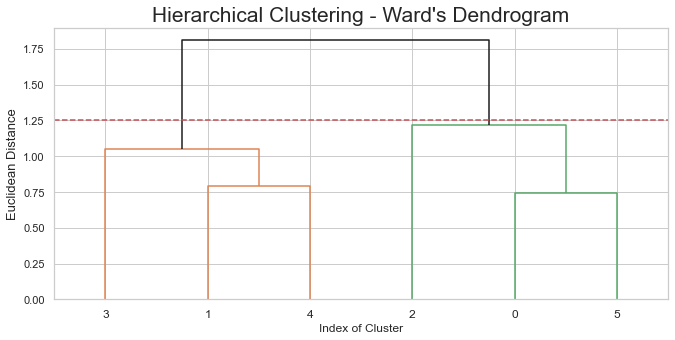

In [19]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
sns.set_style(style="whitegrid")
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 1.25
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Index of Cluster')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [20]:
# 2 cluster solution
df_concat['labels'].replace([3,1,4,2,0,5], [8,8,8,9,9,9], inplace=True)
hc2_labels = df_concat['labels'].values

# METRICS FOR K-means + HIERARCHICAL CLUSTERING EVALUATION

In [21]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_cluster) # get total sum of squares
ssw_labels = df_concat.groupby(['labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) # remember: SST = SSW + SSB
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.289


In [22]:
silhoutte_score = silhouette_score(df_cluster, hc2_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.275


In [23]:
calinski_harabasz = calinski_harabasz_score(df_cluster, hc2_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  26362.022


# Re-introducing the Outliers

In [24]:
X = df[clustering_features]
y = df_concat['labels']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 92.20% of the customers correctly


In [25]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns)

LONGEVITY             0.142219
RAMNTALL              0.017591
NGIFTALL              0.773809
PROP_RESP_CARDPROM    0.000000
HVP4                  0.043047
IC5                   0.023334
EC4                   0.000000
dtype: float64

In [26]:
#imports outliers
path = os.path.join("outliers_notstd.csv")
df_outliers = pd.read_csv(path)

In [27]:
# Scales the data
scaler = RobustScaler()
scaled_feat = scaler.fit_transform(df_outliers[clustering_features])

df_outliers[clustering_features] = scaled_feat

In [28]:
# Predicting the cluster labels of the outliers
df_outliers['labels'] = dt.predict(df_outliers[clustering_features])

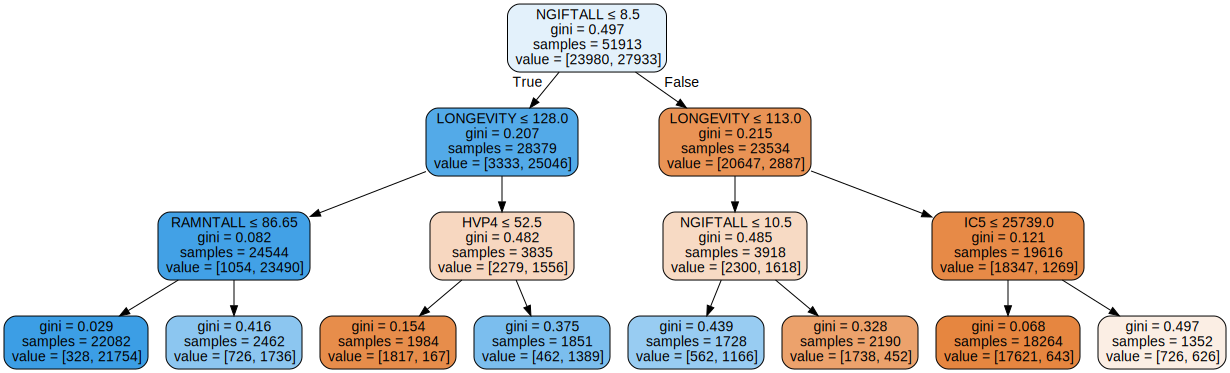

In [29]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)

In [30]:
df_concat.insert(loc=0, column='CONTROLN', value=df['CONTROLN'])  #indexes dont change

In [31]:
df_concat = df_concat.append(df_outliers[["CONTROLN","LONGEVITY","RAMNTALL","NGIFTALL","PROP_RESP_CARDPROM","HVP4","IC5","EC4","labels"]])


In [32]:
#Exporting dataset

In [33]:
df_concat.to_csv('df_kmeans_hc.csv')

# CLUSTER VISUALIZATION USING t-SNE

In [39]:
# This is step can be quite time consuming
#two_dim = TSNE(random_state=42).fit_transform(df_concat) #this does not do clustering, but it detects distinguishable patterns in our data

In [40]:
# t-SNE visualization
#pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_concat['labels'], colormap='tab10', figsize=(15,10))
#plt.show()